In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown, Latex, Image
from tabulate import tabulate
import sys
str1 = ""
sys.path.append(str1)

# Dataset

In [3]:
# read as dataframe using pandas
df = pd.read_excel('data.xls')
display(df.shape)

(6624, 8)

We load the dataset from the given 'data.xls' file. The dataset contains information about different shoes. As observed, we have $6624$ samples and $8$ variables or features in this example. 

**Our objective in this study is to predict the price of a shoe using the given features.**

To get an idea of our dataset, we display the first 5 rows of our dataset. 

In [4]:

display(Markdown(tabulate(df.head(), tablefmt="pipe", headers="keys")))

|    | Type   | Shop   | On_Sale   | For    | Known_Brand   | Leather   | Color   |   Prijs |
|---:|:-------|:-------|:----------|:-------|:--------------|:----------|:--------|--------:|
|  0 | wedges | online | yes       | female | yes           | yes       | black   |   78.3  |
|  1 | wedges | online | no        | female | yes           | yes       | black   |  209.25 |
|  2 | wedges | online | yes       | female | yes           | yes       | brown   |   30.24 |
|  3 | wedges | online | no        | female | yes           | yes       | brown   |  170.1  |
|  4 | wedges | online | yes       | female | yes           | yes       | gray    |   74.25 |

In [5]:
for d in df.columns:
    display(Markdown('* '+d))

* Type

* Shop

* On_Sale

* For

* Known_Brand

* Leather

* Color

* Prijs

**The prices of shoes indicated by the variable `Prijs` is our target variable** and the remaining are the predictors based on which we will predict the value of a test set.

Hence, we use a Regression Tree based model with 7 predictors along with certain model improvements based on Ensemble methods like Bagging and Random Forests. 

We use `scikit-learn` libraries for constructing the models. 

# Default Regression Tree

In [6]:
def get_dummy(df):
    dummy=df
    for col in dummy.columns[:-1]:
        set=dummy[col].unique()
        tmp_dict = dict(zip(set,range(0,len(set))))
        dummy[col] = dummy[col].map(tmp_dict)
    return dummy

In [7]:
dummy = get_dummy(df)
array = dummy.values

In [114]:
X=array[:,0:7] #predictors
Y=array[:,7] #output

We split the dataset and use $70\%$ of it for training the regression tree model and the remaining $30\%$ is kept for testing. 

In [115]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=1234)

In [116]:
display(Markdown('Train size'+'='+str(X_train.shape[0])+' samples'))
display(Markdown('Test size'+'='+str(X_test.shape[0])+ ' samples'))

Train size=4636 samples

Test size=1988 samples

First, we check the prediction on the default implementation with no added improvements. `DecisionTreeRegressor()` function uses the minimizer over mean squared error criterion for finding the partitions.

In [117]:
model = tree.DecisionTreeRegressor(random_state=1234)

In [118]:
rt = model.fit(X_train,Y_train)
Yhat = rt.predict(X_train)

In [119]:
display(Markdown("Train accuracy="+str(rt.score(X_train,Y_train))))

Train accuracy=0.840852930196199

In [120]:
Yhat = rt.predict(X_test)

In [121]:
display(Markdown("Test accuracy="+str(rt.score(X_test,Y_test))))

Test accuracy=0.7452518227601728

We use here the metric of $R^{2}$[^1] score to measure the prediction accuracy. As we see from above, the model does not yet perform well. 

[^1]: $R^{2} = 1 - \frac{\Sigma_{i=1}^{N}(Y_{i} - \hat{Y}_{i})^{2}}{\Sigma_{i=1}^{N}(Y_{i} - \bar{Y}_{i})^{2}}$, where $\hat{y}_i$  represents the predicted value of $y_i$ and $\bar{y}$ is the mean of the observed data.

In [98]:
display(Markdown("Also, note that the RMSE on the test dataset is "+str(mean_squared_error(Yhat,Y_test,squared=False))))

Also, note that the RMSE on the test dataset is 53.084315483289444

## Pruning

Let us now check the results with pruning. We use the Minimal cost complexity pruning approach as discussed in the Lecture. As $\alpha$ increases, more of the tree is pruned. 

In [65]:
path = rt.cost_complexity_pruning_path(X_train,Y_train)
ccp_alphas = path.ccp_alphas

In [66]:
rts = []
for ccp_alpha in ccp_alphas: 
    rt = tree.DecisionTreeRegressor(random_state=1234, ccp_alpha=ccp_alpha)
    rt.fit(X_train,Y_train)
    rts.append(rt)

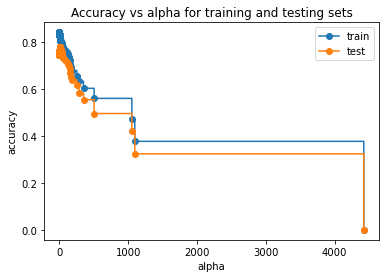

In [73]:
train_scores = [rt.score(X_train, Y_train) for rt in rts]
test_scores = [rt.score(X_test, Y_test) for rt in rts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

Since the default model setting doesn't predict well, pruning seems to be ineffectual using in the model in the original settings, rather the accuracy worsens with the value $\alpha$ increasing. The last element on the plot is the trivial case of 1 node, hence the accuracy shows a value close to zero. 

# Bagging and Random Forests

Let us now see if bagging and random forests approaches improve upon the default Regression Tree model. We use `scikit-learn` implementation of Bagging, the `BaggingRegressor()` function with default settings.

In [184]:
bagg_rt = ensemble.BaggingRegressor(random_state=1234,oob_score=True)
bagg_rt = bagg_rt.fit(X_train,Y_train)
Yhat = bagg_rt.predict(X_test)

/home/arvind/lib/extlib/miniconda3/myenvs/climatenet/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:1069: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [186]:
display(Markdown("Train accuracy="+str(bagg_rt.score(X_train,Y_train))))
display(Markdown("Out of bag accuracy="+str(bagg_rt.oob_score_)))
display(Markdown("Test accuracy="+str(bagg_rt.score(X_test,Y_test))))
display(Markdown("The RMSE on the test dataset is "+str(mean_squared_error(Yhat,Y_test,squared=False))))

Train accuracy=0.8377975995550205

Out of bag accuracy=0.7366532407722062

Test accuracy=0.7394837625063259

The RMSE on the test dataset is 53.681924577271026

Hence, with default settings, the bagging approach doesnt improve on the Regular Regression Tree model. Now, let us check with Random Forests with $m = \sqrt{d}$, where $d$ is the number of predictors. 

In [172]:
rf_rt = ensemble.RandomForestRegressor(random_state=1234,max_features="sqrt",oob_score=True)
rf_rt = rf_rt.fit(X_train,Y_train)
Yhat = rf_rt.predict(X_test)

In [182]:
display(Markdown("Train accuracy="+str(rf_rt.score(X_train,Y_train))))
display(Markdown("Out of bag accuracy="+str(rf_rt.oob_score_)))
display(Markdown("Test accuracy="+str(rf_rt.score(X_test,Y_test))))

Train accuracy=0.8405189512754615

Out of bag accuracy=0.7742454839033515

Test accuracy=0.74587252328458

Hence, there is a marked improvement in the case of Random Forest on the unseen training dataset (out of bag estimate), and a slight improvement on the test dataset. 

## Performance

We compare the test error estimates in the above 2 cases with respect to tree sizes

In [ ]:
test_scores_bag = []
test_scores_rf = []
size = []
for s in range(1,200):
    size.append(s)
    bagg_rt = ensemble.BaggingRegressor(random_state=1234,n_estimators = s, oob_score=True).fit(X_train,Y_train)
    rf_rt = ensemble.RandomForestRegressor(random_state=1234,n_estimators = s, max_features="sqrt",oob_score=True).fit(X_train,Y_train)
    test_scores_bag.append(bagg_rt.score(X_test,Y_test))
    test_scores_rf.append(rf_rt.score(X_test,Y_test))

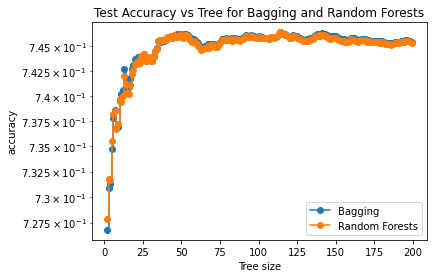

In [199]:
fig, ax = plt.subplots()
ax.set_xlabel("Tree size")
ax.set_ylabel("accuracy")
ax.set_title("Test Accuracy vs Tree for Bagging and Random Forests")
ax.plot(size[1:], test_scores_bag[1:], marker='o', label="Bagging",
        drawstyle="steps-post")
ax.plot(size[1:], test_scores_rf[1:], marker='o', label="Random Forests",
        drawstyle="steps-post")
ax.set_yscale('log')
ax.legend()
plt.show()

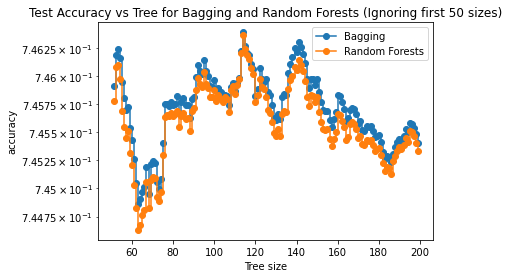

In [200]:
fig, ax = plt.subplots()
ax.set_xlabel("Tree size")
ax.set_ylabel("accuracy")
ax.set_title("Test Accuracy vs Tree for Bagging and Random Forests (Ignoring first 50 sizes)")
ax.plot(size[50:], test_scores_bag[50:], marker='o', label="Bagging",
        drawstyle="steps-post")
ax.plot(size[50:], test_scores_rf[50:], marker='o', label="Random Forests",
        drawstyle="steps-post")
ax.set_yscale('log')
ax.legend()
plt.show()

The performance of both the models show similar trends, eventhough Random Forests performs better with a slight margin. This can be seen in the latter figure, where Random Forest approach always lies with or below the Bagging accuracy samples. 

Note: Due to the computational complexity, we restricted the Tree size sampling to only 200. We expect a better performance by Random Forest model as we increase the tree sizes even further.

## Variable Importance

In the cases of a default Regression Tree and Random Forests model, we analyze the resulting predictor importance.

<BarContainer object of 7 artists>

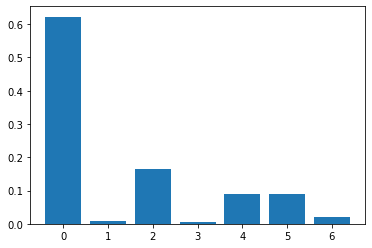

In [204]:
rt_imp=rt.feature_importances_
plt.bar([x for x in range(len(rt_imp))],rt_imp)

<BarContainer object of 7 artists>

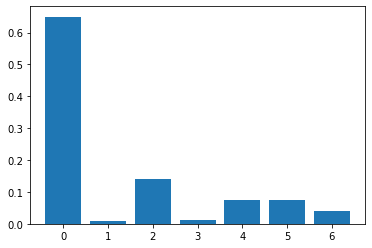

In [205]:
rf_imp=rf_rt.feature_importances_
plt.bar([x for x in range(len(rf_imp))],rf_imp)

Both models show similar results, predictor 0 or `Type` of the shoe has the maximum effect on the price observed, followed by the variable that indicates whether the shoe is on `On_Sale` or not.(seems intuitve!) Attributes like `Brand` and `Leather` have minor influences followed by the rest. 